# Prepare the Data

In [1]:
import pandas as pd
import numpy as np
from plotly.offline import iplot
from Levenshtein import distance

In [2]:
distance('123','1234')

1

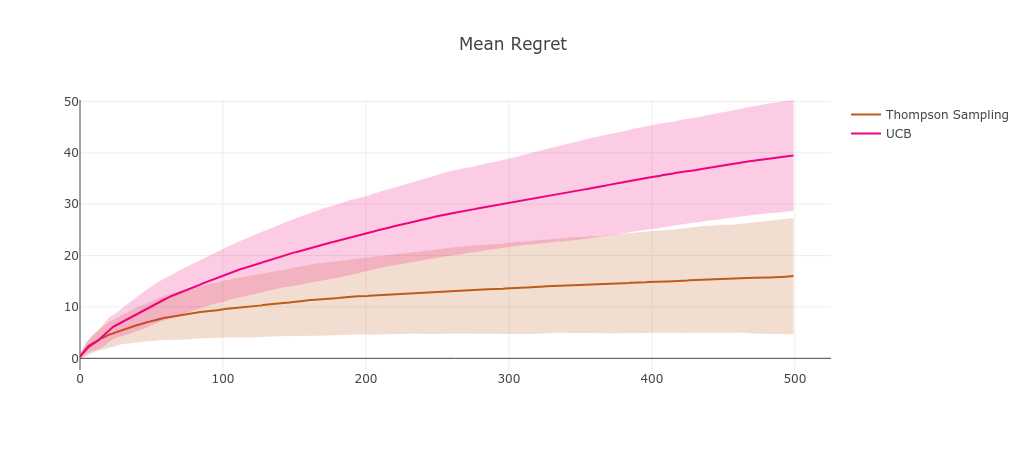

In [3]:
%run Bandits.ipynb

In [4]:
jester_data = pd.read_excel('../data/jester-data-1.xls',header=None)
jester_data.columns = ['count']+list(range(100)) 
jester_data = jester_data.replace(to_replace=99.00,value=-10.0).drop('count',axis=1)

In [5]:
jester_data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,-10.00,-10.00,-10.00,-10.00,-10.00,-5.63,-10.00,-10.00,-10.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,-10.00,-10.00,-10.00,-10.00,9.03,9.27,9.03,9.27,-10.00,-10.00,...,-10.00,-10.00,-10.00,9.08,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00
3,-10.00,8.35,-10.00,-10.00,1.80,8.16,-2.82,6.21,-10.00,1.84,...,-10.00,-10.00,-10.00,0.53,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [6]:
def soft_max(v):
    return np.exp(v) / np.exp(v).sum()

def sample_from_probability(probability_vector):
    return np.random.choice(len(probability_vector), 1, p=probability_vector)

def get_top_ranks(data, n_ranks):
    data_copy = data.copy()
    data_copy.sort(reverse=True)
    return data_copy[:n_ranks]

def simple_regret(v, best_v):
    return np.sqrt(np.mean(np.square(v - best_v)))


In [7]:
simple_regret(np.array([1,2,3]), np.array([3,2,1]))

1.632993161855452

In [8]:
a = [1,2,3,4,5,8,7]
a.sort()
a

[1, 2, 3, 4, 5, 7, 8]

In [9]:
get_top_ranks([1,2,3,4,5,6],4)

[6, 5, 4, 3]

In [10]:
class RBA(object):
    
    def __init__(self, n_ranks, bandit_algorithm_class, k_arms):
        self.n_ranks = n_ranks 
        self.bandit_algorithm_class = bandit_algorithm_class
        self.k_arms = k_arms
        self.reset()
    
    def reset(self):
        self.bandits = [self.bandit_algorithm_class(self.k_arms) for i in range(self.n_ranks)]        
    
    def select_arms(self):
        
        candidate_arms = [bandit.select_arm() for bandit in self.bandits] 
        selected_arms = list()
        
        for candidate_arm in candidate_arms:
            if candidate_arm in selected_arms:
                selected_arms.append(np.random.choice([arm for arm in range(self.k_arms) if arm not in selected_arms]))
            else:
                selected_arms.append(candidate_arm)
        return selected_arms
        
    def update_arms(self, selected_arms, rewards):
        updated_arms = list()
        for i in range(self.n_ranks):
            
            self.bandits[i].update(chosen_arm=selected_arms[i], reward=rewards[i])


In [17]:
class RBASimulation(object):
    
    def __init__(self, data, horizon):
        
        self.data = data
        self.horizon = horizon
    
    def get_click(self, index, arms):
        
        score_vector = self.data.iloc[index, arms].values
        click_probability = soft_max(score_vector)
        candidates = np.random.rand(len(click_probability)) < click_probability

        if True in candidates: 
            return np.argmax(candidates)
        else:
            return False
    
    def get_rewards(self, index, arms):
        
        clicked_arm = self.get_click(index, arms)
        rewards = np.zeros(len(arms))
        
        if clicked_arm is False:
            return rewards
        else:
            rewards[arms==clicked_arm] = 1
            return rewards
    
    def get_simple_regret(self, index, arms):
            
        score_vector = self.data.iloc[index, arms].values
        best_score_vector = get_top_ranks(self.data.iloc[index, :].values,len(arms))

        return simple_regret(score_vector,best_score_vector)
            
    def run(self, n_ranks, bandit_algorithm_class, k_arms, games):
        assert n_ranks < k_arms, 'The number of arms must be bigger then the number of ranks'
        reward_history = np.zeros([self.horizon, games])
        regret_history = np.zeros([self.horizon, games])
        for game in range(games):
            
            rba = RBA(n_ranks, bandit_algorithm_class, k_arms)

            for t in range(self.horizon):
                data_index = np.random.choice(self.data.index)
                selected_arms = rba.select_arms()
                rewards = self.get_rewards(data_index, selected_arms)
                rba.update_arms(selected_arms, rewards)
                reward_history[t,game] = max(rewards)
                regret_history[t,game] = simple_regret(data_index, selected_arms)
        return reward_history , regret_history

In [26]:
sim = RBASimulation(jester_data,20000)

In [27]:
reward_history , regret_history = sim.run(5,ThompsonSampling,100,10)

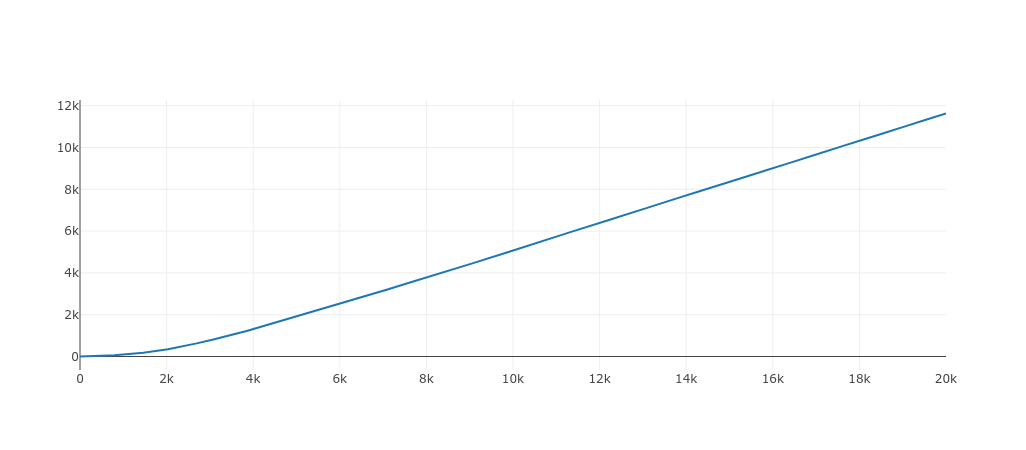

In [29]:
iplot(go.Figure(data=[go.Scatter(x=list(range(20000)),y=reward_history.mean(axis=1).cumsum())]))